# Stokes drifters
In this notebook we check settings for "stokes drifters like" macroplastics. We for now assume: 
1. spherical particles with diameter disk stokes-drifter and buoyancy stokes drifter
2. no wind drag

We look into following things
1. Timescales particles
2. tidal signal
3. testing code for small displacement initial position particles (for simulation to check dispersion effect of field itself)



In [1]:
# reload updated packages
%load_ext autoreload
%autoreload 2


# import needed packages
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import numpy as np
from scipy.optimize import fsolve
plt.style.use('../python_style_Meike.mplstyle')

#import functions
from particle_characteristics_functions import buoyancy_drifter, stokes_relaxation_time
from particle_characteristics_functions import Re_particle, diffusion_time
from particle_characteristics_functions import factor_drag_white1991, factor_drag_Schiller1933, factor_drag_morrison2013
from particle_characteristics_functions import drag_length
from particle_characteristics_functions import find_rep_morrison2013, find_rep_schiller1933, find_rep_white1991
from history_term_functions import History_time




In [15]:
3.724532667 * np.sqrt(3)

6.451079813694014

In [2]:
# Calculating buoyancy and stokes relaxation time for stokes type drifters
# 
d = 0.25 # m diameter outer ring
d_in = 0.2 # m (estimated) dimater inner ring, needed to caluclate volume
h = 0.041  # m (heigth drifter)
m = 0.905 # kg (mass drifter)
cd=0.45 # drag coefficient smooth sphere 
rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water
B = buoyancy_drifter(diameter  = d_in, heigth = h, mass = m, density_fluid = rho_water)
tau = stokes_relaxation_time(d, kinematic_viscosity_water, B)
tau_diff = diffusion_time(d_in, kinematic_viscosity_water)
print(f'B = {B:.2f}')
print(f'tau = {tau:.2f} s')

print(f'tau_diff = {tau_diff:.2f} s')
ld = drag_length(d_in,B,cd)
print(f'ld = {ld} m')


B = 0.68
tau = 2994.76 s
tau_diff = 29134.75 s
ld = 0.7017120538540955 m


2387.567386113758
7104.676659622208
[ 0.72836879  1.45673759  2.18510638  2.91347518  3.64184397  4.37021277
  5.09858156  5.82695035  6.55531915  7.28368794  8.01205674  8.74042553
  9.46879433 10.19716312 10.92553191 11.65390071 12.3822695  13.1106383
 13.83900709 14.56737589 15.29574468 16.02411348 16.75248227 17.48085106
 18.20921986 18.93758865 19.66595745 20.39432624 21.12269504 21.85106383
 22.57943262 23.30780142 24.03617021 24.76453901 25.4929078  26.2212766
 26.94964539 27.67801418 28.40638298 29.13475177 29.86312057 30.59148936
 31.31985816 32.04822695 32.77659574 33.50496454 34.23333333 34.96170213
 35.69007092]
[  7.28368794  14.56737589  21.85106383  29.13475177  36.41843972
  43.70212766  50.9858156   58.26950355  65.55319149  72.83687943
  80.12056738  87.40425532  94.68794326 101.97163121 109.25531915
 116.53900709 123.82269504 131.10638298 138.39007092 145.67375887
 152.95744681 160.24113475 167.5248227  174.80851064 182.09219858
 189.37588652 196.65957447 203.9432624

Text(0, 0.5, 'time [s]')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


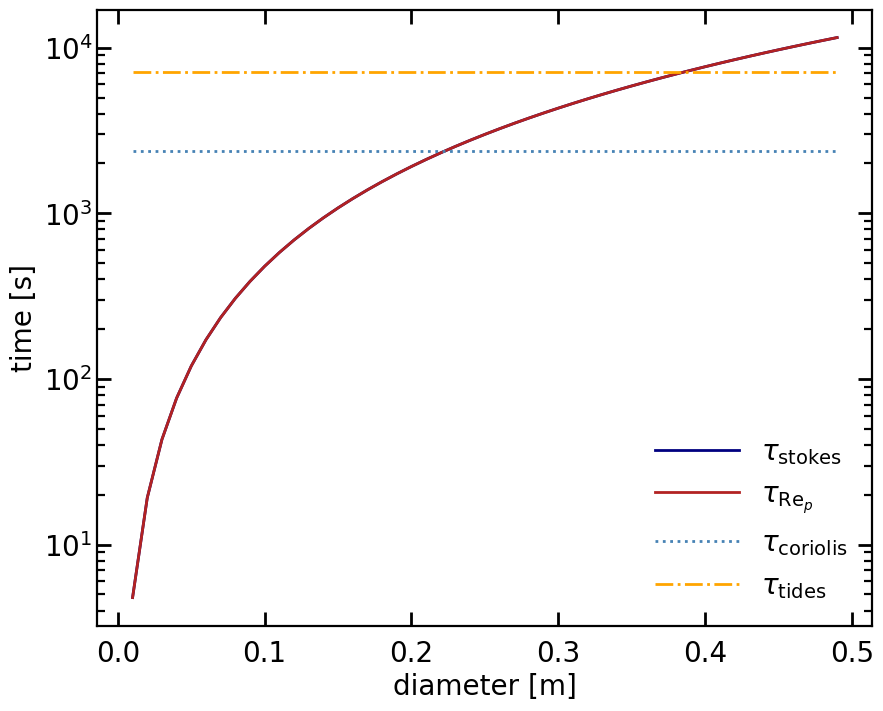

In [3]:
# comparing timescales as function of particle diameter

# particle diameter range between 1 cm and 50 cm
dlist= np.arange(0.01,0.5,0.01) #in m

# stokes relaxation time as function of diameter
tau_stokes = stokes_relaxation_time(diameter = dlist, kinematic_viscosity=kinematic_viscosity_water,buoyancy=B)

# coriolis time scale
tau_coriolis = 1/(2 * (7.2921159 * 10**-5) * np.sin(50*np.pi/180)) * (2*(1-B))/(1+2*B)
print(tau_coriolis)
#tides timescale
tau_tides =  12.4 * 3600 / (2*np.pi)
print(tau_tides)

# Rep>1 drag correction factor, 
Crep = factor_drag_white1991(Re_particle(Uslip = 0.01,diameter = dlist,kinematic_viscosity = kinematic_viscosity_water))
print(Re_particle(Uslip = 0.0001,diameter = dlist,kinematic_viscosity = kinematic_viscosity_water))
print(Re_particle(Uslip = 0.001,diameter = dlist,kinematic_viscosity = kinematic_viscosity_water))
print(Re_particle(Uslip = 0.01,diameter = dlist,kinematic_viscosity = kinematic_viscosity_water))
# drag relaxation time (for non stokes drag (i.e. Rep > 1) given by tau_Rep  = tau_stokes/Crep)
tau_rep = tau_coriolis / Crep

#compare different timescales
fig, ax = plt.subplots()
ax.plot(dlist,tau_stokes,color='navy')
ax.plot(dlist,tau_stokes,color='firebrick')
# ax.plot(dlist,tau_rep,'--',color='firebrick')
ax.plot(dlist,np.full(dlist.size,tau_coriolis),':',color='steelblue')
ax.plot(dlist,np.full(dlist.size,tau_tides),'-.',color='orange')

ax.legend(['$\\tau_{\\mathrm{stokes}}$','$\\tau_{\\mathrm{Re}_p}$','$\\tau_{\\mathrm{coriolis}}$','$\\tau_{\\mathrm{tides}}$'])

ax.set_yscale('log')
ax.set_xlabel('diameter [m]')
ax.set_ylabel('time [s]')



findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


[   711.29765071   1024.26861702   1394.14339539   1820.92198582
   2304.6043883    2845.19060284   3442.68062943   4097.07446809
   4808.37211879   5576.57358156   6401.67885638   7283.68794326
   8222.6008422    9218.41755319  10271.13807624  11380.76241135
  12547.29055851  13770.72251773  15051.05828901  16388.29787234
  17782.44126773  19233.48847518  20741.43949468  22306.29432624
  23928.05296986  25606.71542553  27342.28169326  29134.75177305
  30984.12566489  32890.40336879  34853.58488475  36873.67021277
  38950.65935284  41084.55230496  43275.34906915  45523.04964539
  47827.65403369  50189.16223404  52607.57424645  55082.89007092
  57615.10970745  60204.23315603  62850.26041667  65553.19148936
  68313.02637411  71129.76507092  74003.40757979  76933.95390071
  79921.40403369  82965.75797872  86067.01573582  89225.17730496
  92440.24268617  95712.21187943  99041.08488475 102426.86170213
 105869.54233156 109369.12677305 112925.6150266  116539.0070922
 120209.30296986 123936.50

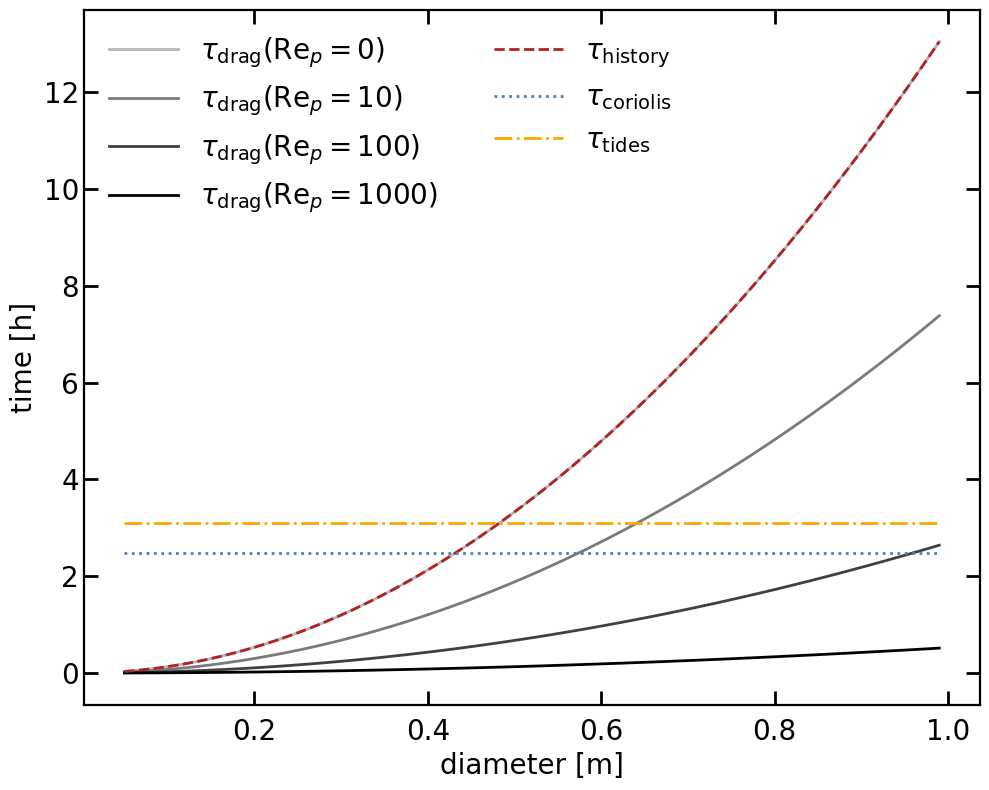

In [3]:
# comparing timescales as function of particle diameter

# particle diameter range between 1 cm and 50 cm
dlist= np.arange(0.05,1,0.01) #in m

# stokes relaxation time as function of diameter
tau_stokes_0 = stokes_relaxation_time(diameter = dlist, kinematic_viscosity=kinematic_viscosity_water,buoyancy=B)

# coriolis time scale
tau_coriolis = 1/(2 * (7.2921159 * 10**-5) * np.sin(50*np.pi/180))# * (2*(1-B))/(1+2*B)

#tides timescale
tau_tides = 0.25 * 12.4 * 3600

Reps = [0,10,100,1000]
# Rep>1 drag correction factor, 
#reps = [factor_drag_white1991(Rep) for Rep in Reps]
# drag relaxation time (for non stokes drag (i.e. Rep > 1) given by tau_Rep  = tau_stokes/Crep)

tau_diff = diffusion_time(dlist, kinematic_viscosity_water)
print(History_time(tau_diff, 1))
print(tau_stokes_0)
tau_history =[ tau_stokes_0 for  Rep in Reps ]
tau_stokes = [tau_stokes_0/ factor_drag_white1991(Rep) for Rep in Reps]
fig, ax = plt.subplots()
#compare different timescales
n_lines = 4
cmap_blues = plt.colormaps['Greys']

# Take colors at regular intervals spanning the colormap.
blues = cmap_blues(np.linspace(0.4, 1, n_lines))

for i in range(0,4,1):

    ax.plot(dlist,tau_stokes[i]/3600,color=blues[i])
ax.plot(dlist,tau_history[0]/3600,'--',color='firebrick')
# ax.plot(dlist,tau_rep,'--',color='firebrick')
ax.plot(dlist,np.full(dlist.size,tau_coriolis)/3600,':',color='steelblue')
ax.plot(dlist,np.full(dlist.size,tau_tides)/3600,'-.',color='orange')

ax.legend([ '$\\tau_{\\mathrm{drag}}$(Re$_p=0$)','$\\tau_{\\mathrm{drag}}$(Re$_p=10$)','$\\tau_{\\mathrm{drag}}$(Re$_p=100$)','$\\tau_{\\mathrm{drag}}$(Re$_p=1000$)','$\\tau_{\\mathrm{history}}$','$\\tau_{\\mathrm{coriolis}}$','$\\tau_{\\mathrm{tides}}$'],ncol=2)

# ax.set_yscale('log')
ax.set_xlabel('diameter [m]')
ax.set_ylabel('time [h]')
# ax.set_title('Re$_p$ = ' + f'{Reps[i]}',fontsize=20)
fig.tight_layout()
fig.savefig('../figures/timescales_diameter_Rep.pdf')


8950.812817801474


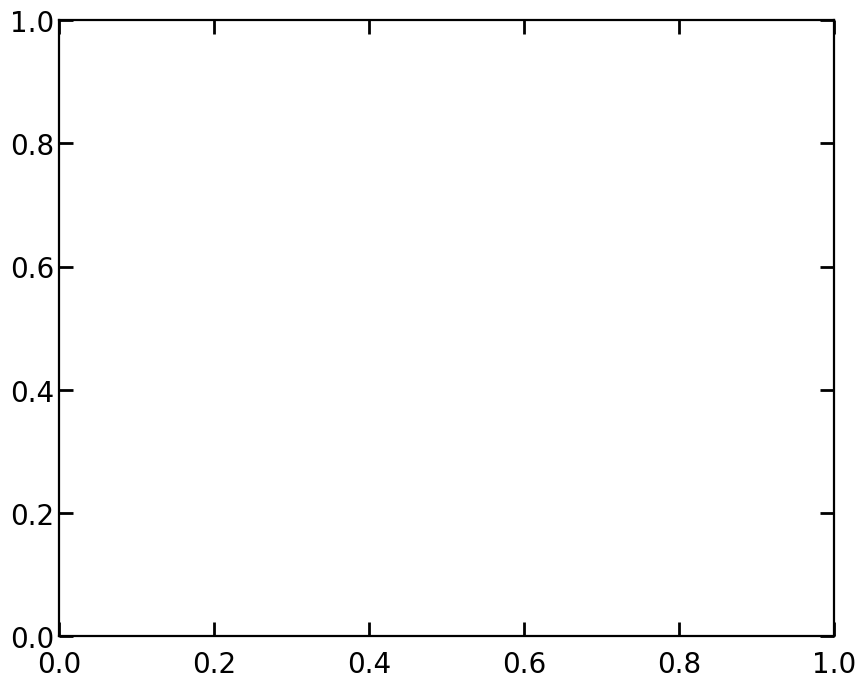

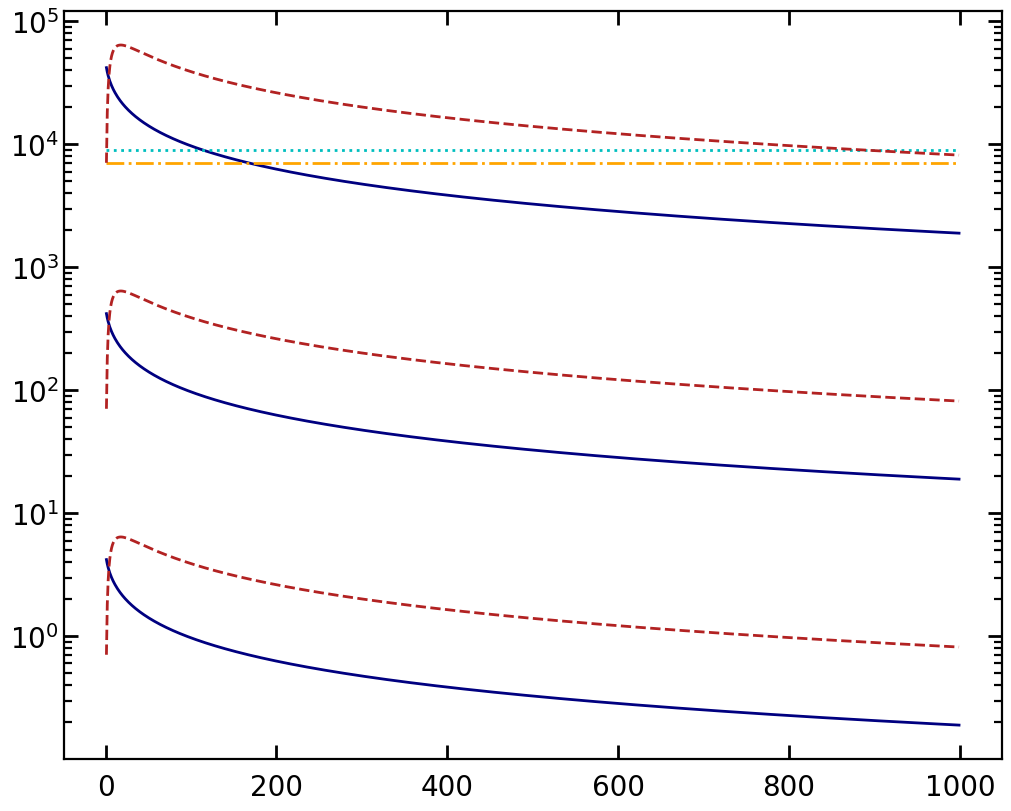

In [ ]:
dlist= np.array([0.01,0.10,1]) #in m

# stokes relaxation time as function of diameter
tau_stokes_0 = stokes_relaxation_time(diameter = dlist, kinematic_viscosity=kinematic_viscosity_water,buoyancy=B)
Rep = np.arange(1,1000,1)
Crep = factor_drag_white1991(Rep)

tau_stokes = np.array([ts/Crep for ts in tau_stokes_0])

#tides timescale
tau_tides =  12.4 * 3600 / (2*np.pi)

# coriolis time scale
tau_coriolis = 1/(2 * (7.2921159 * 10**-5) * np.sin(50*np.pi/180))# * (2*(1-B))/(1+2*B)
print(tau_coriolis)
tau_diff = diffusion_time(dlist, kinematic_viscosity_water)
tau_H=  np.array([History_time(td,Rep) for td in tau_diff])
tau_history = tau_stokes*tau_stokes * Crep / tau_H

fig, ax = plt.subplots()
n_lines = 3
cmap_blues = plt.colormaps['Blues']
cmap_reds = plt.colormaps['Reds']

# Take colors at regular intervals spanning the colormap.
blues = cmap_blues(np.linspace(0.2, 1, n_lines))
reds = cmap_reds(np.linspace(0.1,0.9,n_lines))

fig, ax = plt.subplots(layout='constrained')
ax.plot(Rep,tau_stokes[0],'-',color='navy')#blues[0])
ax.plot(Rep,tau_stokes[1],'-',color='navy')#=blues[1])
ax.plot(Rep,tau_stokes[2],'-',color='navy')#=blues[2])
ax.plot(Rep,np.full(Rep.size,tau_tides),'-.',color='orange')
ax.plot(Rep,np.full(Rep.size,tau_coriolis),':',color='c')
ax.plot(Rep,tau_history[0],'--', color='firebrick')# = reds[0])
ax.plot(Rep,tau_history[1],'--', color='firebrick')#color = reds[1])
ax.plot(Rep,tau_history[2],'--', color='firebrick')#color = reds[2])
ax.set_yscale('log')


8512.768239463674


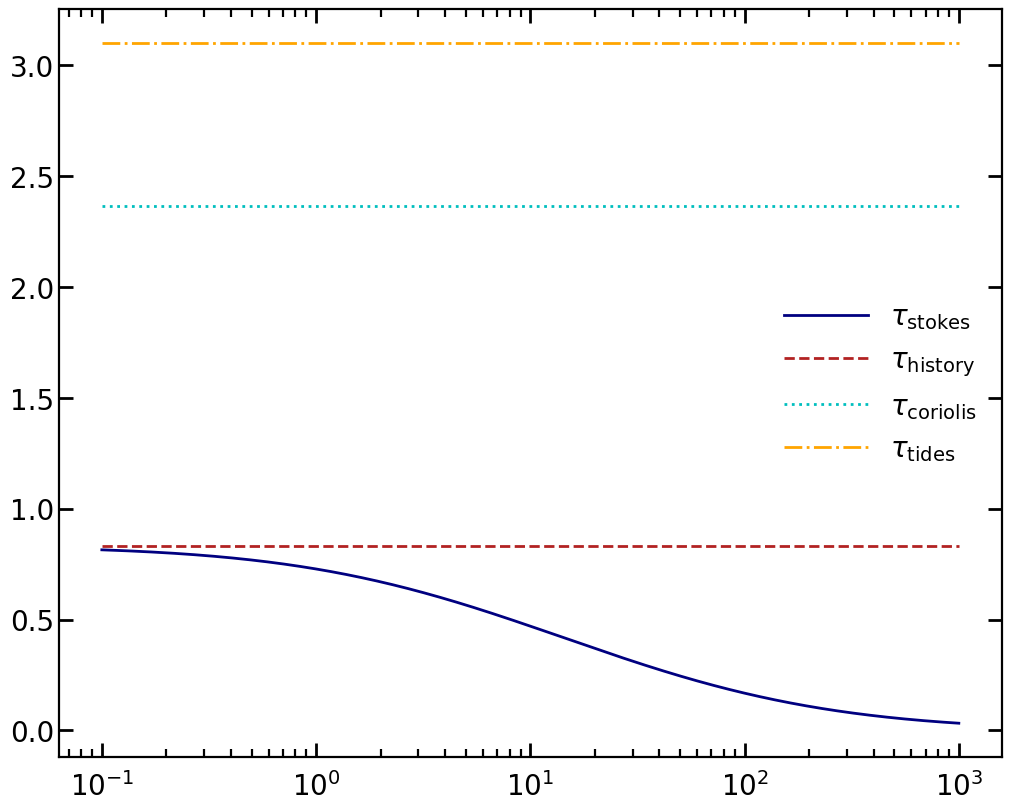

In [ ]:
d = 0.25

# stokes relaxation time as function of diameter
tau_stokes_0 = stokes_relaxation_time(diameter = d, kinematic_viscosity=kinematic_viscosity_water,buoyancy=B)
Rep = np.logspace(-1,3,1000)
Crep = factor_drag_white1991(Rep)

tau_stokes = tau_stokes_0/Crep

#tides timescale
tau_tides =  0.25 * 12.4 * 3600 # / (2* np.pi)

# coriolis time scale
tau_coriolis = 1/(2 * (7.2921159 * 10**-5) * np.sin(53.655*np.pi/180))# * (2*(1-B))/(1+2*B)
print(tau_coriolis)
tau_diff = diffusion_time(d, kinematic_viscosity_water)
tau_H=  History_time(tau_diff,Rep)
tau_history = tau_stokes*tau_stokes * Crep / tau_H



fig, ax = plt.subplots(layout='constrained')
ax.plot(Rep,tau_stokes/3600,'-',color='navy')#blues[0])
ax.plot(Rep,np.full(Rep.size,tau_stokes_0)/3600,'--', color='firebrick')# = reds[0])\
ax.plot(Rep,np.full(Rep.size,tau_coriolis)/3600,':',color='c')
ax.plot(Rep,np.full(Rep.size,tau_tides)/3600,'-.',color='orange')



# ax.set_yscale('log')

ax.set_xscale('log')
ax.legend(['$\\tau_{\\mathrm{stokes}}$','$\\tau_{\\mathrm{history}}$','$\\tau_{\\mathrm{coriolis}}$','$\\tau_{\\mathrm{tides}}$'])
ax.set_ylabel('time')


8950.812817801474


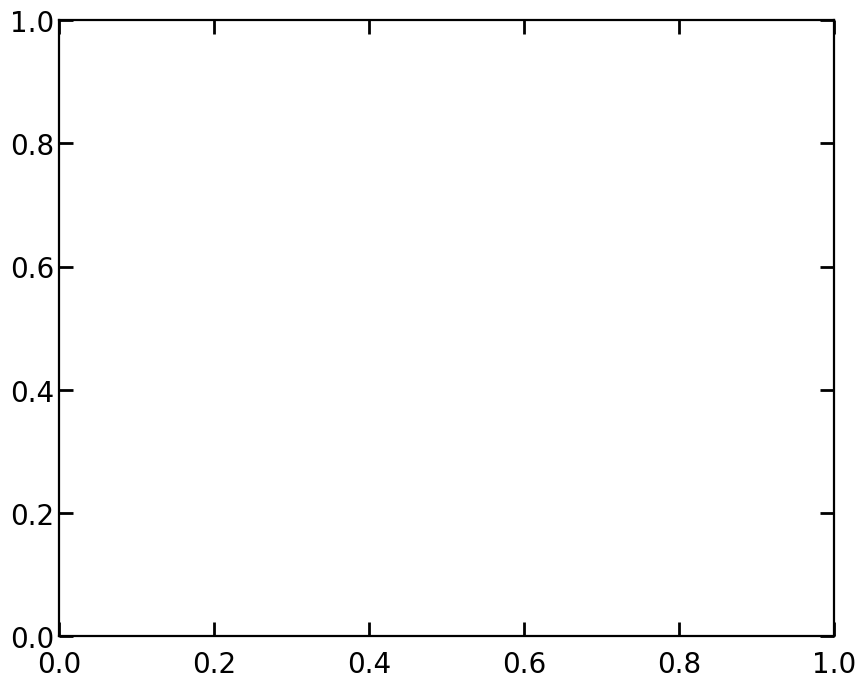

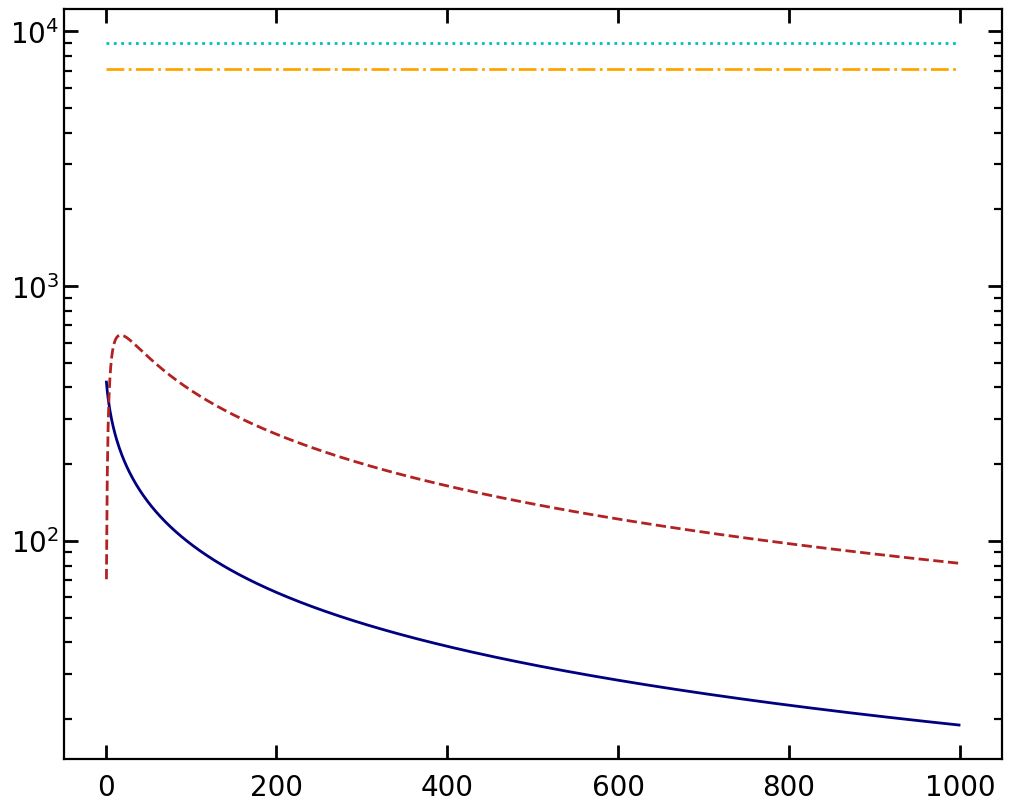

In [43]:
dlist= np.array([0.01,0.10,0.25,1]) #in m

# stokes relaxation time as function of diameter
tau_stokes_0 = stokes_relaxation_time(diameter = dlist, kinematic_viscosity=kinematic_viscosity_water,buoyancy=B)
Rep = np.arange(1,1000,1)
Crep = factor_drag_white1991(Rep)

tau_stokes = np.array([ts/Crep for ts in tau_stokes_0])

#tides timescale
tau_tides =  12.4 * 3600 / (2*np.pi)

# coriolis time scale
tau_coriolis = 1/(2 * (7.2921159 * 10**-5) * np.sin(50*np.pi/180))# * (2*(1-B))/(1+2*B)
print(tau_coriolis)
tau_diff = diffusion_time(dlist, kinematic_viscosity_water)
tau_H=  np.array([History_time(td,Rep) for td in tau_diff])
tau_history = tau_stokes*tau_stokes * Crep / tau_H

fig, ax = plt.subplots()
n_lines = 3
cmap_blues = plt.colormaps['Blues']
cmap_reds = plt.colormaps['Reds']

# Take colors at regular intervals spanning the colormap.
blues = cmap_blues(np.linspace(0.2, 1, n_lines))
reds = cmap_reds(np.linspace(0.1,0.9,n_lines))

fig, ax = plt.subplots(layout='constrained')
# ax.plot(Rep,tau_stokes[0],'-',color='navy')#blues[0])
ax.plot(Rep,tau_stokes[1],'-',color='navy')#=blues[1])
# ax.plot(Rep,tau_stokes[2],'-',color='navy')#=blues[2])
ax.plot(Rep,np.full(Rep.size,tau_tides),'-.',color='orange')
ax.plot(Rep,np.full(Rep.size,tau_coriolis),':',color='c')
# ax.plot(Rep,tau_history[0],'--', color='firebrick')# = reds[0])
ax.plot(Rep,tau_history[1],'--', color='firebrick')#color = reds[1])
# ax.plot(Rep,tau_history[2],'--', color='firebrick')#color = reds[2])
ax.set_yscale('log')


In [ ]:
clist =[]
for d in dlist:
    
    sol1 = fsolve(find_rep_white1991,0.1*1000*d,(tau_coriolis,tau_tides,B,kinematic_viscosity_water,d))
 
    sol2 = fsolve(find_rep_morrison2013,0.1*d,(tau_coriolis,tau_tides,B,kinematic_viscosity_water,d))


    clist.append(factor_drag_morrison2013(sol2[0]))

print(clist)

[2.2547501358996875, 4.27089909310328, 6.631642854772238, 9.32268266884083, 12.313263400814572, 15.579122725985988, 19.101228313988226, 22.864228425776922, 26.855416304375762, 31.064050371710806, 35.48089404505005, 40.09789319952452, 44.907942886724854, 49.9047139622706, 55.08252119835016, 60.43622092093998, 65.96113016837243, 71.65296186922127, 77.5077721657571, 83.52191709711035, 89.69201660068481, 96.01492431034862, 102.48770200020662, 109.10759779092652, 115.87202743285657, 122.77855812724475, 129.82489445821716, 137.0088660929391, 144.32841697327805, 151.78159577346005, 159.3665474386419, 167.08150565141975, 174.9247860990085, 182.8947804345726, 190.98995084305167, 199.2088251356127, 207.54999230820636, 216.01209850910016, 224.5938433680727, 233.29397664649258, 242.11129517299855, 251.04464003413548, 260.09289399323615, 269.2549791141875, 278.5298545695721, 287.9165146152135, 297.4139867150088, 307.0213298022416, 316.73763266461066]


In [ ]:
#drag_relaxation time = tstokes /C(Rep) as function of t:
dlist= np.arange(0.01,1,0.01) #in m
tau_stokes = stokes_relaxation_time(diameter= dlist, kinematic_viscosity=kinematic_viscosity_water,B=B)
Crep = factor_drag_white1991(Re_particle(0.0001,dlist,kinematic_viscosity_water))
fcor =(2 * (7.2921159 * 10**-5) * np.sin(50*np.pi/180))
fig, ax = plt.subplots()
ax.plot(dlist,tau_stokes*fcor * 2*(1-B)/(1 + 2 * B),color='navy')
ax.plot(dlist,tau_stokes/Crep*fcor * 2*(1-B)/(1 + 2 * B),color='navy')
# ax.plot(dlist,tau_stokes/10,color='firebrick')
# ax2=ax.twinx()
# ax2.plot(dlist,Crep)
# ax.axhline(tcoriolis,color='grey',zorder=-5)


TypeError: stokes_relaxation_time() got an unexpected keyword argument 'viscosity_water'

In [55]:
d=0.25
d*d*1.2*10**(4)/2387.567386113758

0.31412725955382337

In [75]:
5/300

0.016666666666666666

In [49]:
 1.2*10**(2)/7104.676659622208 + 1.2*10**(2)/2387.567386113758

0.06715064461242783

In [ ]:
rho_PE = 961 # kg / m^3
tau_PE = stokes_relaxation_time(1/10, kinematic_viscosity_water, rho_PE / rho_water)
print(tau_PE)

580.9692671394798


In [38]:
stokes_relaxation_time(1, kinematic_viscosity_water, B) * 2 * ( 1- B) / (1 + 2*  B)

12781.290530633822

Text(0.5, 0, '$\\mathrm{Re}_p$')

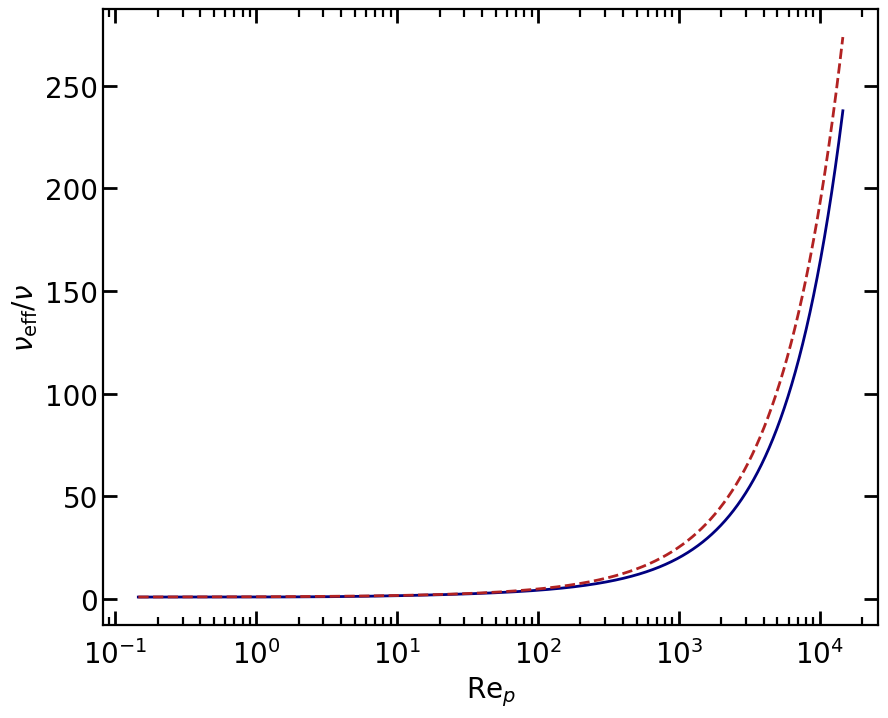

In [7]:
# check drag factor ( and force)
Uslip=np.arange(0.000001,0.1,0.000001)
REp = Re_particle(Uslip,d_in,kinematic_viscosity_water)
f_drag = factor_drag(Uslip,d_in,kinematic_viscosity_water,B)
fdrag2 = factor_drag_2(Uslip,d_in,kinematic_viscosity_water)
fig,ax = plt.subplots()
ax.plot(REp,f_drag,color='navy')
ax.plot(REp,fdrag2,'--',color='firebrick')
ax.set_xscale('log')
ax.set_ylabel('$\\nu_{\\mathrm{eff}}/\\nu$')
ax.set_xlabel('$\\mathrm{Re}_p$')
# ax.plot(REp[0:], (24/REp  + 
#               2.6 * (REp / 5.) / (1 + (REp/5.)**(1.52))  +
#               0.25 * (REp) / ((10**6) + REp  )
#             ) )

# ax.plot(REp[0:], (24/REp)   )
# ax.set_yscale('log')

# calculate drag force as function of slip velocity
Calvert,...,Bremer claim that non-viscous drag force is significantly smaller than its viscous equivalent and I do not see this happening?
So I will test it for particle of 10cm with viscosity water of 10^-6 resulting in Rep = uslip 10^5 
we use the newtoninan formulation of the drag force and the morrison2023 formulation of the drag coefficient

In [4]:
def CD_morrison2013(Rep):
    """
    Emperical stokes drag correction factor valid up to Rep < 10^6 from
    [1] F. A. Morrison, An introduction to fluid mechanics (2013)
    """
    c_REp = (24/Rep + 
             2.6 * (Rep / 5.) / (1 + (Rep/5.)**(1.52))  +
             0.411 * (Rep / (2.63 * 10**5))**(-7.94) / (1 + (Rep / (2.63 * 10**5))**(-8)) +
             0.25 * (Rep) / ((10**6) + Rep  )
            )
    #tau_inv = 36 * nu * f_REp /( (1. + 2. * B) * L**2)
    return c_REp#tau_inv

def Rep(U,nu,d):
    return U * d / nu

def F_drag(U, Cd, rho_f, d):
    A = np.pi * d * d / 4
    return 0.5 * Cd * rho_f * A * U * U

def F_stokes(U,rho_f,nu,d):
    return 3 * np.pi * rho_f * nu * d * U

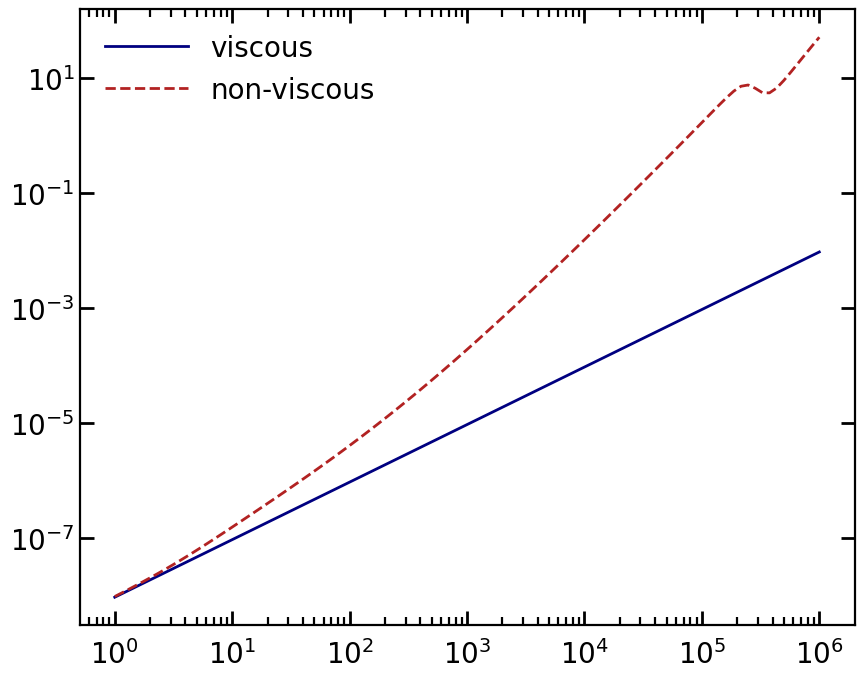

In [10]:
nu = 10**(-6)
rho = 10**3
d = 0.1
U=np.logspace(-5,1,100)

rep = Rep(U, nu, d)
cd = CD_morrison2013(rep)
fdrag = F_drag(U,cd,rho,d)
fstokes = F_stokes(U,rho,nu,d)

fig,ax=plt.subplots()
ax.plot(rep,fstokes,'-',color='navy')
ax.plot(rep,fdrag,'--',color='firebrick')
ax.legend(['viscous','non-viscous'])
ax.set_xscale('log')
ax.set_yscale('log')

# Test displacacment code

In [4]:
# test displacement code

def displace_coordinates(lon, lat, d, B):
    """
    Function that displaces point(s) given by lon, lat over a distance d
    (in meters) in direction B (angle measured clockwise in radians from the
    north pole). The function returns the lon and lat coordinates of the
    displaced point(s).
    """
    Rearth = 6371 * 10**3 # radius earth in m
    lon_rad = lon * np.pi/180. 
    lat_rad = lat * np.pi/180. 
    lat_new = np.arcsin(np.sin(lat_rad) * np.cos(d / Rearth)+np.cos(lat_rad) * np.sin( d/ Rearth) * np.cos(B))
    lon_new = lon_rad + np.arcsin( np.sin(d / Rearth) * np.sin(B) / np.cos(lat_new))
    lat_new_angle = lat_new * 180/np.pi 
    lon_new_angle = lon_new * 180/np.pi 
    return lon_new_angle, lat_new_angle




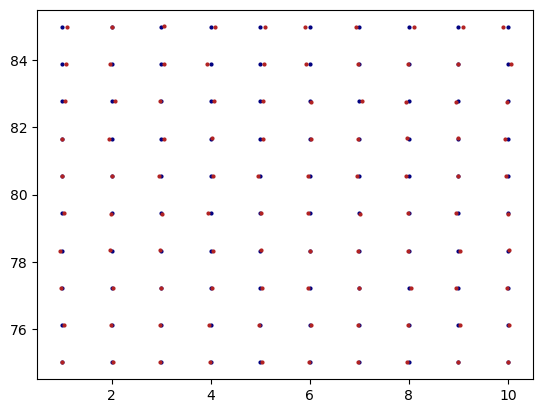

In [7]:
lon = np.linspace(1,10,10)
lat = np.linspace(75,85,10)
lon_particles, lat_particles = np.meshgrid(lon,lat)
lon_particles = lon_particles.flatten()
lat_particles = lat_particles.flatten()
nparticles=lat_particles.size
d = 1000 # displacement in meters
theta = np.random.rand(nparticles)*2*np.pi

lon_d, lat_d = displace_coordinates(lon_particles,lat_particles,d,theta)

fig,ax = plt.subplots()
ax.plot(lon_particles,lat_particles, 'o',color='navy',markersize=2)
ax.plot(lon_d,lat_d, 'o',color='firebrick',markersize=2)

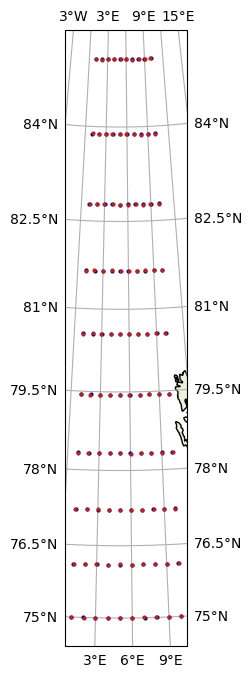

In [16]:

proj = ccrs.LambertConformal(central_longitude=5, central_latitude=80)

fig, ax = plt.subplots(facecolor="w", figsize=(20,8),
    subplot_kw=dict(projection=proj),
)

    
ax.plot(lon_particles,lat_particles, 'o',color='navy',markersize=2,zorder=20, transform=ccrs.PlateCarree())
ax.plot(lon_d,lat_d, 'o',color='firebrick',markersize=2,zorder=20, transform=ccrs.PlateCarree())

# ax.set_extent((1, 10, 75, 85))
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='k')
gl = ax.gridlines(
    draw_labels=True, rotate_labels=False,
    x_inline=False, y_inline=False,
)

# Theoretical tides plot

Text(0, 0.5, 'difference in displacement [km]')

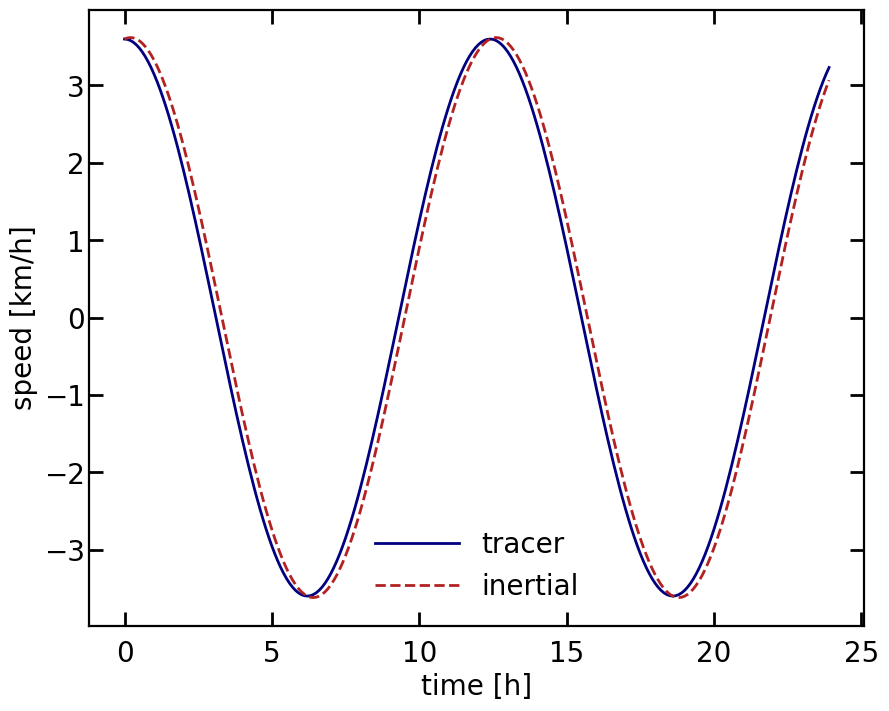

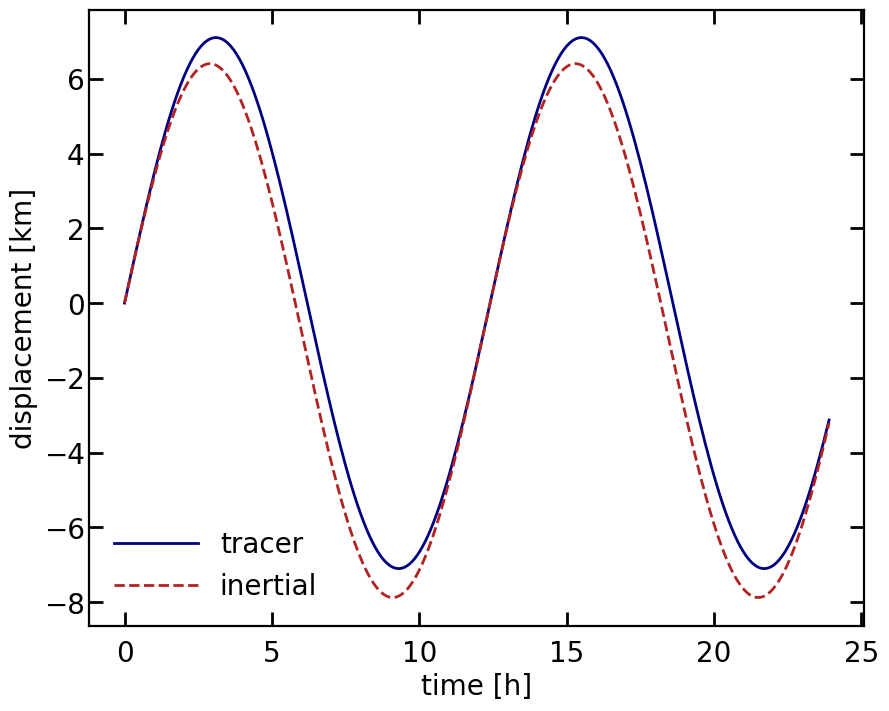

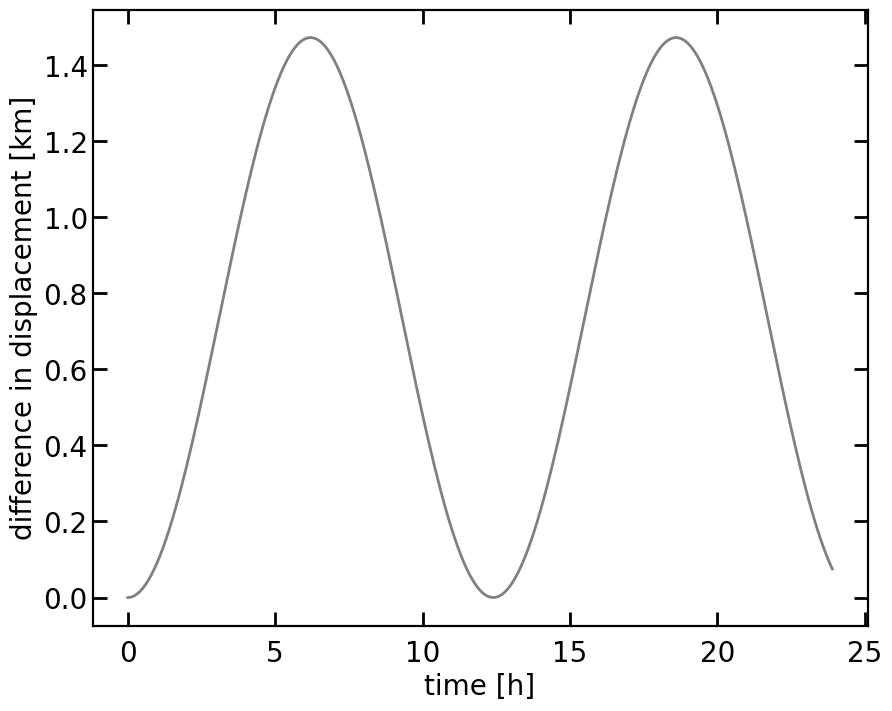

In [6]:
# theoretical tides plot
def Utide(A, f, t):
    return A * np.cos(f * t * 2 * np.pi)

def UMRtide(A,f,t,tau, B):
    factor = tau * 2 * (1 - B) / (2 * B + 1)
    return Utide(A, f, t) + factor * A * f * 2 * np.pi *  np.sin(f * t * 2 * np.pi)

def Xtidetracer(A, f, t):
    return A / (f * 2 * np.pi) * np.sin(f * t * 2 * np.pi)

def XtideMR(A,f,t, tau, B):
    factor = tau * 2 * (1 - B) / (2 * B + 1)  
    return Xtidetracer(A,f,t) + factor * Utide (A, f, t)


f = 1 / (12.4 ) # period is 12.4 h
A = 3.6 # km/h
tlist = np.arange(0,24,0.1)
fig,ax=plt.subplots()
ax.plot(tlist,Utide(A, f, tlist),color='navy')
ax.plot(tlist,UMRtide(A,f,tlist,tau/3600,B),'--',color='firebrick')
ax.set_xlabel('time [h]')
ax.set_ylabel('speed [km/h]')
ax.legend(['tracer','inertial'])

fig2,ax2=plt.subplots()
ax2.plot(tlist,Xtidetracer(A, f, tlist),color='navy')
ax2.plot(tlist,XtideMR(A,f,tlist,tau/3600,B) - XtideMR(A,f,0,tau/3600,B),'--',color='firebrick')
ax2.set_xlabel('time [h]')
ax2.set_ylabel('displacement [km]')
ax2.legend(['tracer','inertial'])

fig3,ax3=plt.subplots()
ax3.plot(tlist,Xtidetracer(A, f, tlist)-(XtideMR(A,f,tlist,tau/3600,B) - XtideMR(A,f,0,tau/3600,B)),color='grey')
ax3.set_xlabel('time [h]')
ax3.set_ylabel('difference in displacement [km]')